In [2]:
from pyteomics import mzxml, auxiliary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import mz2n,rtsbaseB
from Chemometrics.basic import read_mzxml,get_rtrange
import pickle
import uuid
import sys
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
plt.rcParams['figure.figsize'] = (20, 6)
%matplotlib inline

In [1]:
df = read_mzxml("./data010.mzXML")
df = df.round(5).astype(np.float32)
df.head()

NameError: name 'read_mzxml' is not defined

- round

5位

In [163]:
df.sort_values(by='mz',inplace=True)

- 过滤双电荷

单电荷mz+Na/2 = 双电荷的mz

In [22]:
Na = 22.989769

In [23]:
#平均质谱图
df['cat']= (df.mz.diff() > .06).cumsum()
df['mz'] = df.groupby('cat')['mz'].transform('mean')

- 去掉保留时间小于0.5分钟的组分mz
- 去掉保留时间最后0.5分钟的组分mz

In [24]:
dfbase = df.loc[~df.mz.isin(df.loc[df.rt<.5].mz)]
dfbase = dfbase.loc[~dfbase.mz.isin(dfbase.loc[dfbase.rt>(df.rt.max()-1)].mz)]

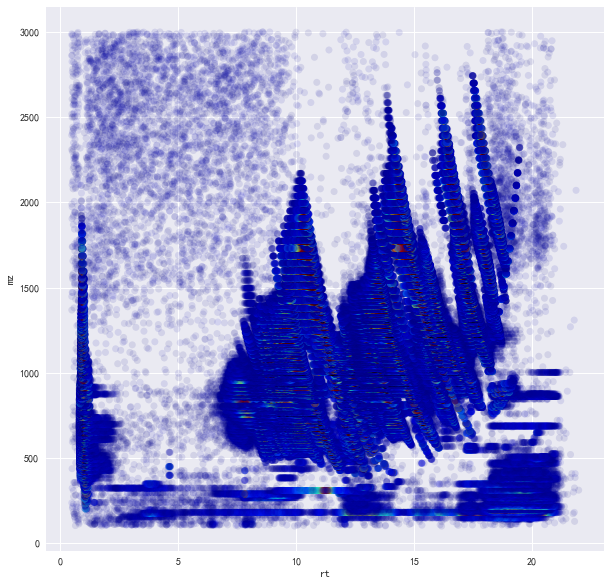

In [25]:
data = dfbase
#fig_name = 'mass-dfbase.png'
vmax = np.percentile(data.intensity,90)
plt.rcParams['figure.figsize'] = (10,10)
plt.scatter(data.rt,data.mz,c=data.intensity,vmax=vmax,alpha=0.1, cmap="jet", edgecolors="none")
plt.xlabel('rt')
plt.ylabel('mz')
#plt.savefig(fig_name,dpi = 300)

- 单个mz的 count小于10的去掉

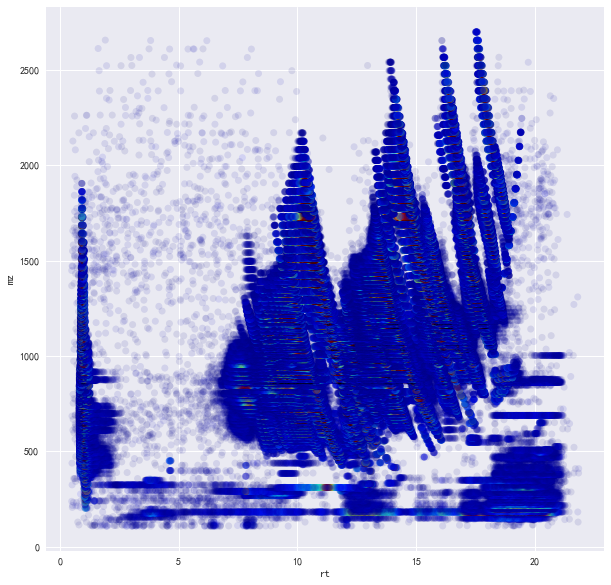

In [26]:
df_mzcount = dfbase.groupby('mz').filter(lambda x: len(x) > 10)
data = df_mzcount
#fig_name = 'mass-dfbase.png'
vmax = np.percentile(data.intensity,90)
#plt.rcParams['figure.figsize'] = (10, 10)
plt.scatter(data.rt,data.mz,c=data.intensity,vmax=vmax,alpha=0.1, cmap="jet", edgecolors="none")
plt.xlabel('rt')
plt.ylabel('mz')
#plt.savefig(fig_name,dpi = 300)

# 去掉不连续的mz

In [3]:
df = read_mzxml("./data010.mzXML")
df = df.round(5).astype(np.float32)
df = df.sort_values(by='mz')
df.head()

,intensity,rt,mz
223926,235.000763,8.53138,100.072632
98557,281.079987,1.59615,100.073418
521786,231.174530,9.98188,100.073769
204868,248.116730,8.30062,100.073967
130493,302.802185,4.80623,100.074142


- mz group

In [4]:
mz_threshold = 1e-2
df['cat_mz'] = (df.mz.diff()>mz_threshold).cumsum()

- rt group

In [7]:
df = df.sort_values('rt')
grp = df.groupby('cat_mz')
rt_threshold = 0.0041*5

In [9]:
def f(x):
    b = (x.sort_values().diff()>rt_threshold).cumsum()
    return b[x.index]
def f1(x):
    b = (x.sort_values().diff()>rt_threshold).cumsum()
    return b
a = grp['rt'].transform(f1)

In [10]:
df['cat_rt'] = a.astype(np.int32)
#b.drop(['cat'],axis =1, inplace=True)
df.loc[df.cat_mz==0].head()

,intensity,rt,mz,cat_mz,cat_rt
0,693.519653,0.04263,100.075630,0,0
34,626.852112,0.04675,100.075653,0,0
63,219.064468,0.05087,100.083839,0,0
62,823.145386,0.05087,100.075958,0,0
95,956.172729,0.05498,100.076530,0,0


- f1 和 f2等效

In [11]:
grp = df.groupby(['cat_mz','cat_rt'])
df = grp.filter(lambda x:len(x)>2)
grp = df.groupby(['cat_mz','cat_rt'])

In [12]:
def f2(x):
    w = x.intensity/x.intensity.sum()
    rt = x.rt.dot(w)
    mz = x.mz.dot(w)
    return [rt,mz]

In [13]:
s = grp.apply(f2)

In [14]:
from Chemometrics.basic import psave
psave(s,'s.p')

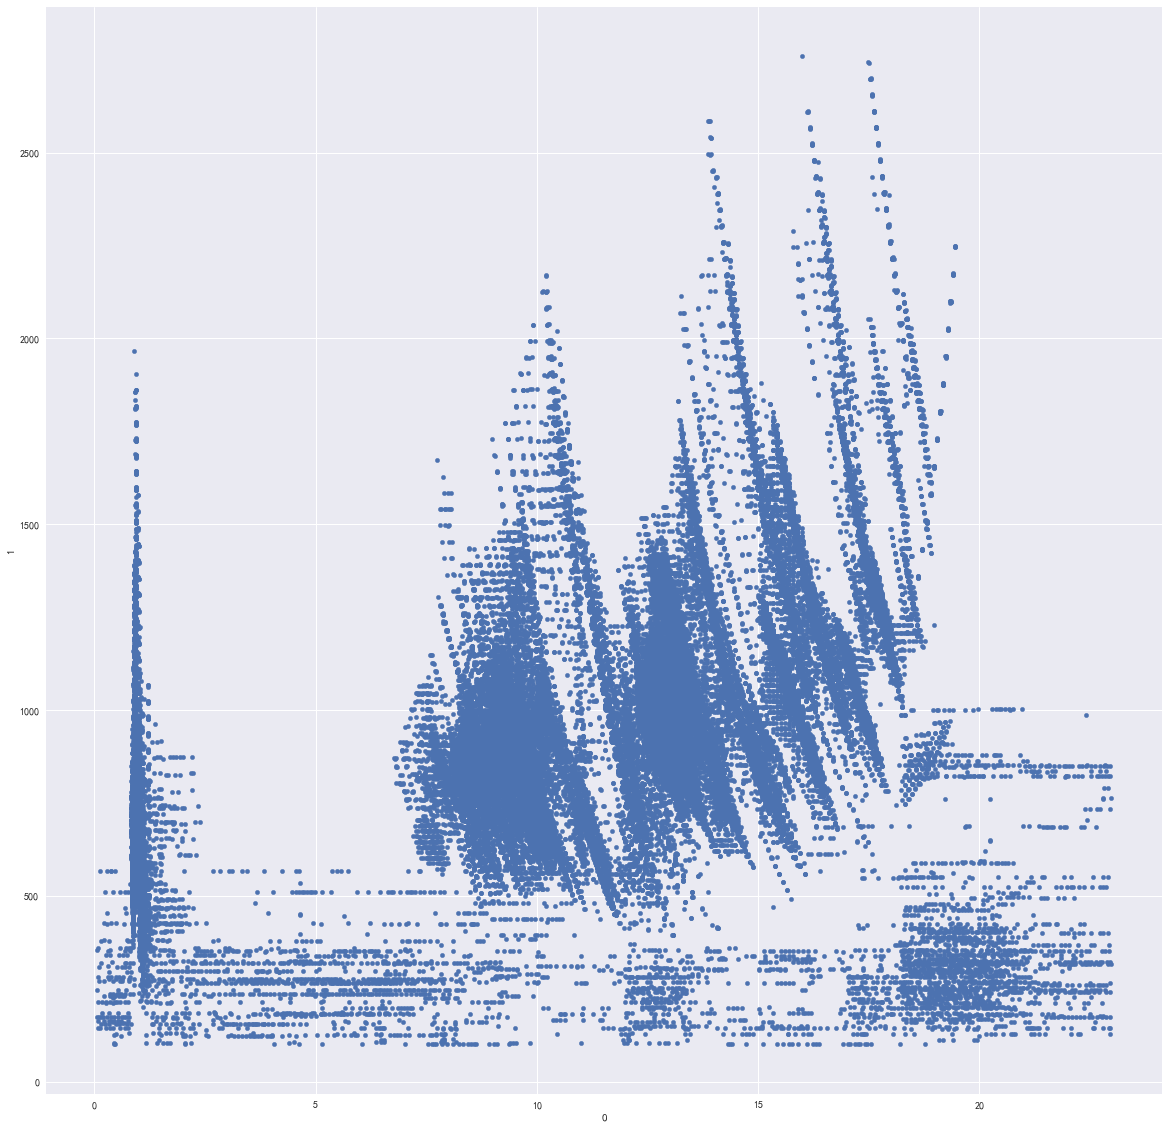

In [24]:
plt.rcParams['figure.figsize'] = (20, 20)
pd.DataFrame(np.vstack(s.values)).plot.scatter(0,1)

- 单双电荷

去掉有单电荷的双电荷

In [192]:
mz = df_mzcount.mz.unique()
a = (abs(((mz-Na)*2).reshape(-1,1)-mz)<.1)

In [193]:
mz1 = mz[~a.any(axis=1)]

In [219]:
z1 = df_mzcount.loc[df_mzcount.mz.isin(mz1)]
z1 = z1.groupby(['rt','mz']).mean().reset_index()#相同rt，相同mz 合并强度

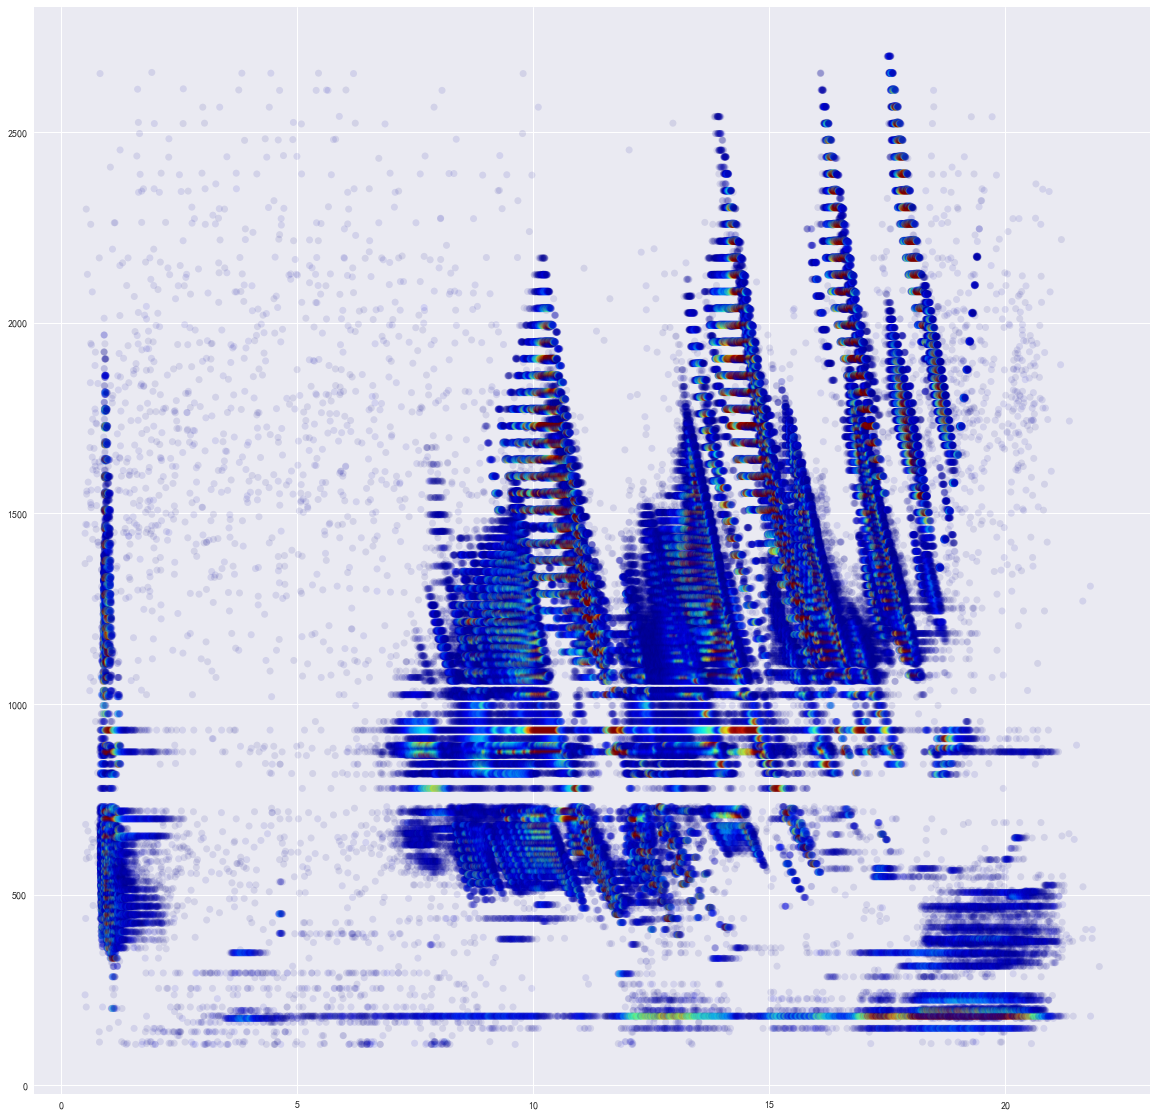

In [220]:
data = z1
vmax = np.percentile(data.intensity,90)
plt.rcParams['figure.figsize'] = (20, 20)
plt.scatter(data.rt,data.mz,c=data.intensity,vmax=vmax,alpha=0.1, cmap="jet", edgecolors="none")

- 同位素

In [216]:
#z1.loc[z1.rt == z1.loc[z1.rt>10].rt.values[1]].plot.bar('mz','intensity')
z1 = z1.groupby(['rt','mz']).sum().reset_index()

In [150]:
def filter_homo(mz_list, mass_num, base_on):
    #特征离子质量过滤 #过滤44
    mass_mask = np.any(abs((np.round(mz_list.values.reshape(-1, 1) - base_on )+ .01) % mass_num) < .1, axis=1)
    return mass_mask

In [240]:
df.sort_values(by='rt').rt.round(4).diff().unique()

array([    nan,  0.    ,  0.0042,  0.0041,  0.0041,  0.0042,  0.0041,
        0.0042,  0.0041,  0.0042,  0.0041,  0.0042,  0.0041,  0.0042,
        0.0042,  0.0041,  0.0042,  0.0041,  0.0042,  0.0041,  0.0042,
        0.0041,  0.0042,  0.0041,  0.0042,  0.004 ,  0.004 ])

In [254]:
df.sort_values(by='mz').mz.round(4).diff().fillna(0).sort_values()

223926     0.0000
1314966    0.0000
922123     0.0000
1490288    0.0000
976229     0.0000
986443     0.0000
966283     0.0000
947805     0.0000
1006060    0.0000
1304466    0.0000
977309     0.0000
21165      0.0000
988793     0.0000
965148     0.0000
1491820    0.0000
940478     0.0000
951014     0.0000
412488     0.0000
1002605    0.0000
953141     0.0000
1306483    0.0000
1315926    0.0000
1315311    0.0000
1461652    0.0000
1455382    0.0000
1604319    0.0000
1599718    0.0000
1599022    0.0000
1605167    0.0000
1601485    0.0000
            ...  
143533     1.0384
1686462    1.0690
1589495    1.0713
200796     1.0816
106185     1.0846
32         1.0872
143374     1.1083
143887     1.1248
106686     1.1249
173572     1.1279
112303     1.1290
170351     1.1311
121088     1.1350
763403     1.1581
99603      1.1709
1518915    1.2075
105232     1.2253
123295     1.2289
150578     1.2349
121687     1.2449
470140     1.2646
1668281    1.2649
1314801    1.4187
144417     1.4303
74375     

In [182]:
np.percentile((df.mz/df.rt).sort_values(),99)

1113.6059937322286

In [157]:
a = np.round(abs(mz.reshape(-1,1)-mz))%44

In [158]:
b= a+np.identity(len(a))

In [166]:
np.all(np.sum(b<.1,axis=1))
#全范围校正

True

In [143]:
dfB = df.loc[df.rt.between(*rt_all.loc['B',['实测保留时间起点','实测保留时间终点']])]

NameError: name 'rt_all' is not defined

In [ ]:
dfB = df.loc[df.rt.between(*rt_all.loc['B',['实测保留时间起点','实测保留时间终点']])]
vmax = np.percentile(dfB.intensity,90)
plt.rcParams['figure.figsize'] = (20, 20)
plt.scatter(dfB.rt,dfB.mz,c=dfB.intensity,vmax=vmax,alpha=0.1, cmap="jet", edgecolors="none")
plt.xlim(df.rt.min(),df.rt.max())
fig_name = 'mass-B-'+str(uuid.uuid4())+'.png'
plt.xlabel('rt')
plt.ylabel('mz')
plt.savefig(fig_name,dpi = 300)